## **Advanced Machine Learning-- Assignment-01**
---
### **Name:-Arnab Bera       , Roll No:- MDS202409**
---
### **Name:-Biswajit Kala   ,    Roll No:-MDS202412**
---

### **Task-1:Classifier for notMNIST: This dataset contains images of alphabets A to J in various fonts. Your task is to build a classifier for this dataset using CNN.**
- **Classify each image into one of 10 classes**
- **Show the effect of permuting the image pixels on CNN classifiers**


In [1]:
#### Import all necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import itertools
import torch.nn.functional as F
from collections import defaultdict
from datasets import load_dataset
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(423)

In [2]:
#### The 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:

#### Step 1: Load the notMNIST dataset
print("LOADING MNIST DATASET...........")
ds=load_dataset("anubhavmaity/notMNIST")
print(f"DATASET STRUCTUTRE:-{ds}")
print(f"NUMBER OF TRAINING SAMPLES:{len(ds['train'])}")
print(f"NUMBER OF TESTING SAMPLES:{len(ds['test'])}")


LOADING MNIST DATASET...........


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-66ec62000fa1b4(…):   0%|          | 0.00/7.10M [00:00<?, ?B/s]

data/test-00000-of-00001-1136ef192260594(…):   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14979 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3745 [00:00<?, ? examples/s]

DATASET STRUCTUTRE:-DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
})
NUMBER OF TRAINING SAMPLES:14979
NUMBER OF TESTING SAMPLES:3745


In [4]:
smaple_image=ds['train'][0]['image']
print("-"*50)
print("Type:-",type(smaple_image))
print("-"*50)
print("SIZE (Widht x Height):-",smaple_image.size)
print("-"*50)
print("Channels:-",smaple_image.mode)
print("-"*50)

### So, all the image in gray scale


--------------------------------------------------
Type:- <class 'PIL.PngImagePlugin.PngImageFile'>
--------------------------------------------------
SIZE (Widht x Height):- (28, 28)
--------------------------------------------------
Channels:- L
--------------------------------------------------


In [5]:
####  UNIQUE LABEL PRESENT IN THE DATASET
unique_labels=set(ds['train']['label'])
num_classes=len(unique_labels)
print(f"Number of classes in the dataset:{num_classes}")
print(f"Classes Are-:{sorted(unique_labels)}")
#### notMNIST dataset  has letters A-J {A:0,B:1,C:2,D:3,E:4,F:5,G:6,H:7,I:8,J:9}
class_names=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


Number of classes in the dataset:10
Classes Are-:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
INPUT_SIZE=28*28*1
OUTPUT_SIZE=10


Visualizing training samples


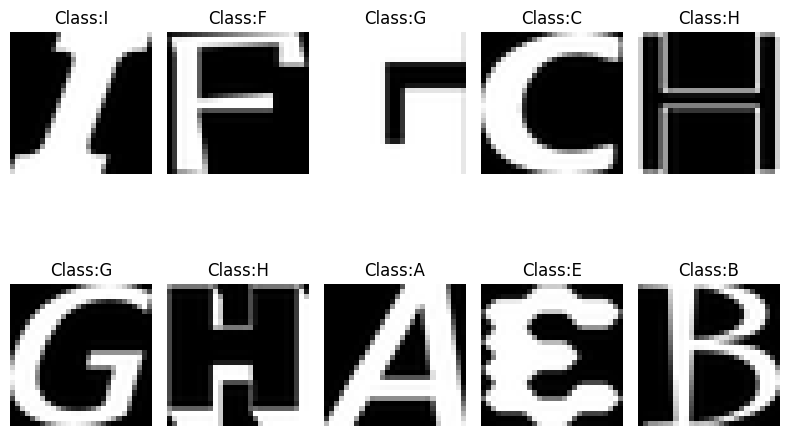

In [7]:
#### Step 2: Visualize some dataset samples
def visualize_samples(dataset, num_samples=10):
    #### Visualize the random samples from the dataset
    fig,axes=plt.subplots(2, 5, figsize=(8, 6))
    axes=axes.ravel()

    for i in range(num_samples):
        ####Get random sample using random function
        idx=random.randint(0, len(dataset) - 1)
        sample=dataset[idx]
        image=sample['image']
        label=sample['label']

        #### Display image
        axes[i].imshow(image,cmap='gray')
        axes[i].set_title(f'Class:{class_names[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing training samples")
visualize_samples(ds['train'])


In [8]:
#### Step 3: Custom Dataset class for notMNIST
class ImageDataset(Dataset):
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        sample=self.dataset[index]
        image=sample['image']
        label=sample['label']
        #### Apply transformations on the dataset
        if self.transform:
            image=self.transform(image)
        return image, label

In [9]:
#### Step 4: Data transformation functions
def Transform_data(image_size=28):

    train_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    val_transform=transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5])
    ])

    return train_transform, val_transform


In [10]:

def load_the_data(dataset,batch_size,image_size):
    """Load and prepare data with proper transforms"""
    ### Load the data set and prepare data with transofrms
    #### Transform the dataset
    train_tfrm,val_tfrm=Transform_data(image_size)

    #### Training Data
    train_data = ImageDataset(dataset['train'],transform=train_tfrm)
    #### Testing data
    test_data = ImageDataset(dataset['test'],transform=val_tfrm)

    #### Data Loaders
    train_load=DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,

    )
    test_load=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,

    )

    return train_load, test_load
train_loader,test_loader=load_the_data(ds,batch_size=64,image_size=28)

In [11]:
### function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np
acc_store=[]
def train_model(epoch,model):
  model.train()
  for b_idx,(data,target) in enumerate(train_loader):
    ## send to device
    data,target=data.to(device),target.to(device)

    optimizer.zero_grad()
    output=model(data)
    loss=F.nll_loss(output,target)
    loss.backward()
    optimizer.step()

    if b_idx % 100==0:
       print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, b_idx * len(data), len(train_loader.dataset),
                100. * b_idx / len(train_loader), loss.item()))
def test_model(model):
  model.eval()
  test_loss=0
  correct=0
  for data,target in test_loader:
    ### Data sent to device
    data,target=data.to(device),target.to(device)
    output=model(data)
    test_loss += F.nll_loss(output,target,reduction='sum').item()
    pred = output.data.max(1, keepdim=True)[1]

    correct += pred.eq(target.data.view_as(pred)).cpu().sum()
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  acc_store.append(accuracy)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    accuracy))



In [12]:
class Flatten(nn.Module):
    def forward(self, x):
      return x.view(x.size(0), -1)

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.C = 64
        self.network = nn.Sequential(
                # Layer 0
                nn.Conv2d(1, self.C, kernel_size=3, stride=1,
                          padding=1, bias=True),
                nn.BatchNorm2d(self.C),
                nn.ReLU(),

                # Layer 1
                nn.Conv2d(self.C, self.C*2, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*2),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 2
                nn.Conv2d(self.C*2, self.C*4, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*4),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 3
                nn.Conv2d(self.C*4, self.C*8, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*8),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 4
                nn.AdaptiveAvgPool2d(1),
                Flatten(),
                nn.Linear(self.C*8, output_size, bias=True),
                nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        return self.network(x)

In [13]:
print("Training on ", device)
model_cnn = CNN(INPUT_SIZE, OUTPUT_SIZE).to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
model_cnn2=CNN(INPUT_SIZE,OUTPUT_SIZE).to(device)
for epoch in range(0, 20):
    train_model(epoch, model_cnn)
    test_model(model_cnn)

Training on  cuda:0
Number of parameters: 1556874
Train Epoch: 0 [0/14979 (0%)]	Loss: 2.389021
Train Epoch: 0 [6400/14979 (43%)]	Loss: 0.570703
Train Epoch: 0 [12800/14979 (85%)]	Loss: 0.496585

Test set: Average loss: 0.6377, Accuracy: 3059/3745 (82%)

Train Epoch: 1 [0/14979 (0%)]	Loss: 0.689705
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.377715
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.336356

Test set: Average loss: 0.3871, Accuracy: 3337/3745 (89%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.166453
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.262644
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.263064

Test set: Average loss: 0.7209, Accuracy: 2981/3745 (80%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.461294
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.234842
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.193854

Test set: Average loss: 0.6599, Accuracy: 2995/3745 (80%)

Train Epoch: 4 [0/14979 (0%)]	Loss: 0.516330
Train Epoch: 4 [6400/14979 (43%)]	Loss: 0.073200
Train Epoch: 4 [12800/14979 (85%)]	Loss:



---



#### **Prediction of the test network**

In [14]:
def visualize_prediction(image,pred_prob,real_label):
  #### This is the function where we viewing an image and it's predicted class
  fig,(ax1,ax2)=plt.subplots(figsize=(6,8),ncols=2)
  ax1.imshow(image.cpu().numpy().squeeze(),cmap='gray')
  ax1.axis('off')
  pred=np.argmax(pred_prob)
  ax1.set_title([class_names[real_label],class_names[pred]])

  ax2.barh(np.arange(10),pred_prob)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(10))
  ax2.set_yticklabels(class_names)
  ax2.set_title('Prediction Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

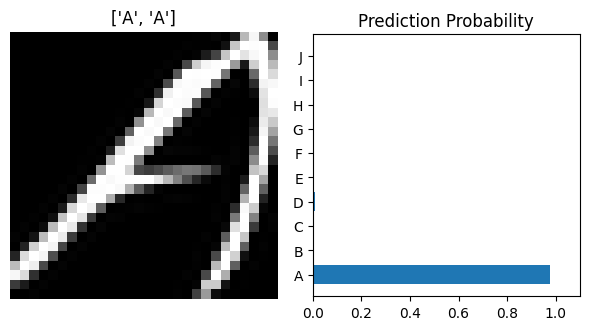

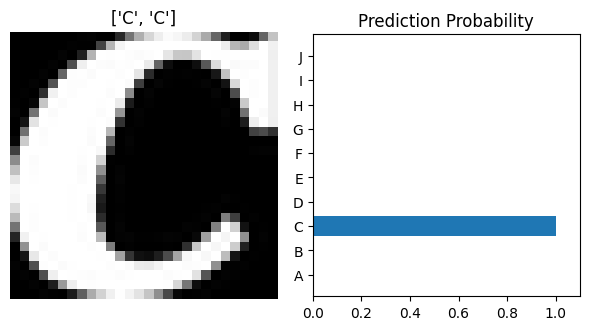

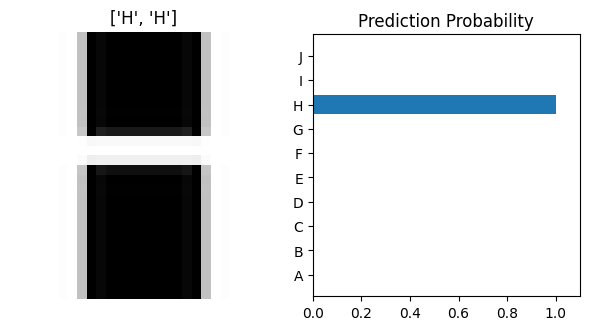

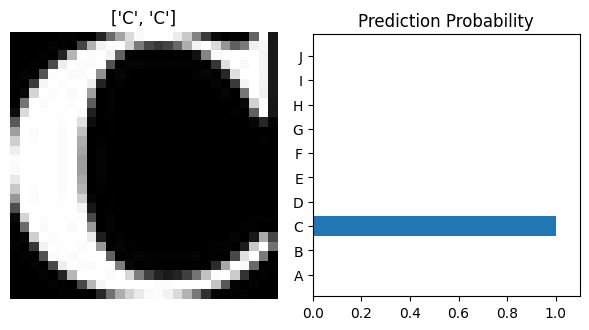

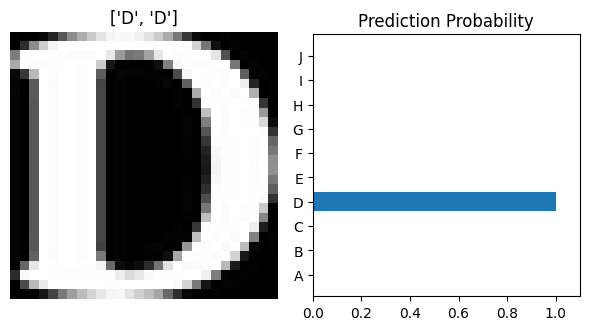

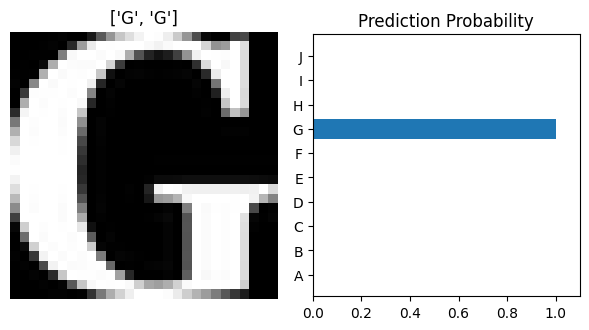

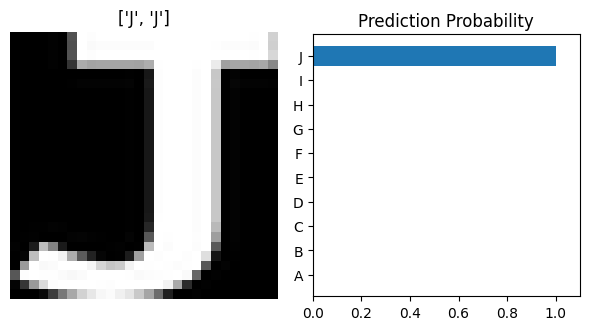

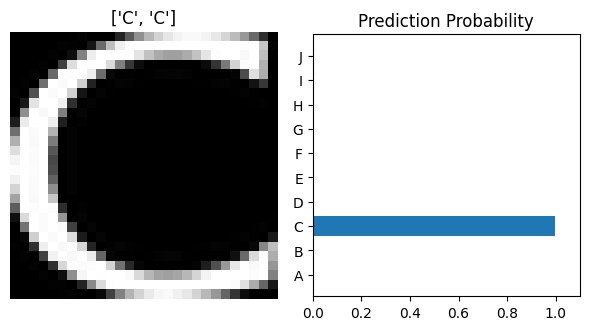

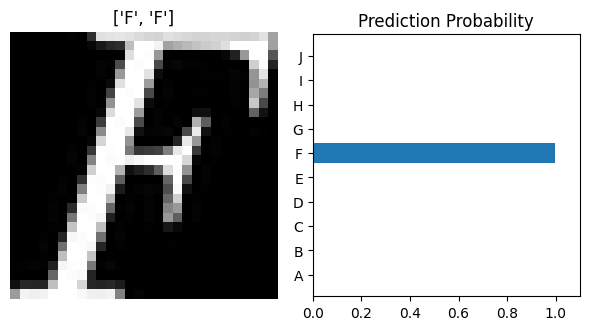

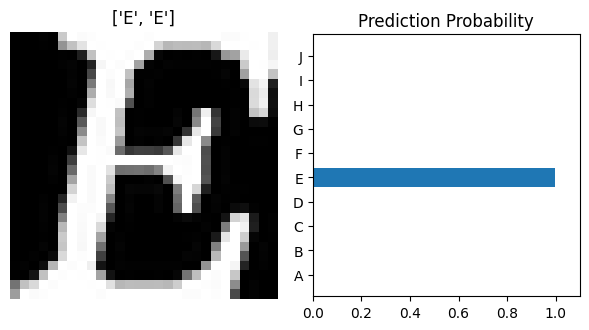

In [15]:
model_cnn.to('cpu')
image_batch, label_batch = next(iter(test_loader))

with torch.no_grad():
    log_pred = model_cnn(image_batch)

for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_probability = log_pred[i]

    pred_prob = torch.exp(log_probability).cpu().numpy().squeeze()
    visualize_prediction(img, pred_prob, real_label)

#### **Visual Information**

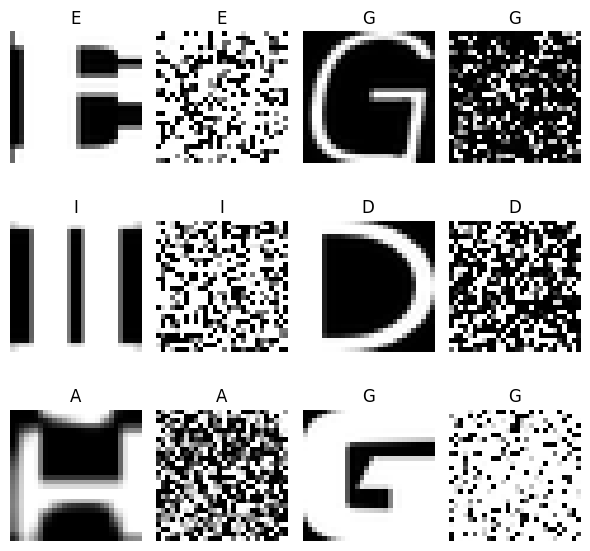

In [16]:
fixed_perm = torch.randperm(1*28*28)
plt.figure(figsize=(6, 6))
images, labels = next(iter(train_loader))

for i in range(6):
    img=images[i]
    img_perm=img.view(-1,28*28*1).clone()
    img_perm=img_perm[:,fixed_perm]
    img_perm=img_perm.view(1,28,28)

    target=labels[i]
    plt.subplot(3,4,2*i+1)

    plt.imshow(img.squeeze(),cmap='gray')
    plt.axis('off')
    plt.title(class_names[target])

    plt.subplot(3,4,2*i+2)
    plt.imshow(img_perm.squeeze(),cmap='gray')
    plt.axis('off')
    plt.title(class_names[target])

plt.tight_layout()
plt.show()


In [17]:

def permu_train(epoch, model, perm=torch.arange(0, 28*28).long()):
    model.train()
    for b_idx, (data, label) in enumerate(train_loader):
        # Permute pixels
        data = data.view(-1, 28*28)[:, perm].view(-1, 1, 28, 28).to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, label)
        loss.backward()
        optimizer.step()

        if b_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, b_idx * len(data), len(train_loader.dataset),
                100. * b_idx / len(train_loader), loss.item()))

def permu_test(model, perm=torch.arange(0, 28*28).long()):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(-1, 28*28)[:, perm].view(-1, 1, 28, 28).to(device)
            label = label.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, label, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return accuracy

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training On:", device)


Training On: cuda


In [18]:

# Initialize optimizer
optimizer = optim.SGD(model_cnn2.parameters(), lr=0.01, momentum=0.5)

In [19]:
#### Train the network
print("Training On:-",device)
print("Numebr of parameters:{}".format(get_n_params(model_cnn2)))

for epoch in range(0,20):
  permu_train(epoch,model_cnn2,fixed_perm)
  permu_test(model_cnn2,fixed_perm)

Training On:- cuda:0
Numebr of parameters:1556874
Train Epoch: 0 [0/14979 (0%)]	Loss: 2.436226
Train Epoch: 0 [6400/14979 (43%)]	Loss: 0.948790
Train Epoch: 0 [12800/14979 (85%)]	Loss: 0.785940

Test set: Average loss: 2.4970, Accuracy: 1310/3745 (35%)

Train Epoch: 1 [0/14979 (0%)]	Loss: 0.970768
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.368119
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.450582

Test set: Average loss: 0.7409, Accuracy: 2845/3745 (76%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.633609
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.401428
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.339342

Test set: Average loss: 0.6517, Accuracy: 2999/3745 (80%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.384337
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.219028
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.282121

Test set: Average loss: 1.0177, Accuracy: 2691/3745 (72%)

Train Epoch: 4 [0/14979 (0%)]	Loss: 0.328010
Train Epoch: 4 [6400/14979 (43%)]	Loss: 0.313509
Train Epoch: 4 [12800/14979 (85%)]	Loss:

#### **Visualize the prediction**

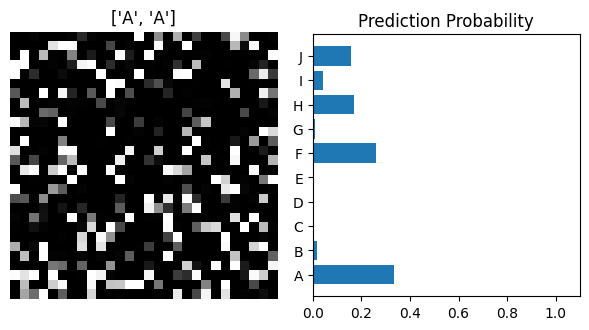

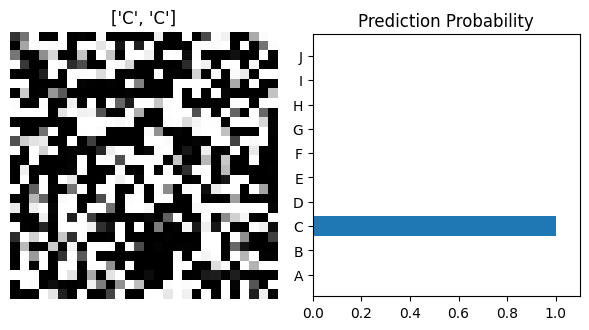

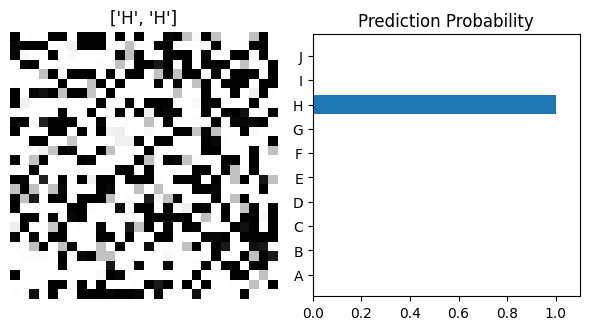

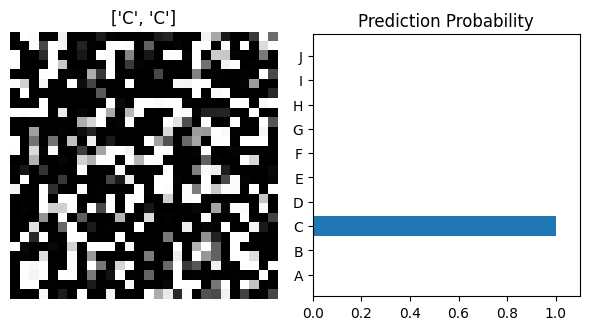

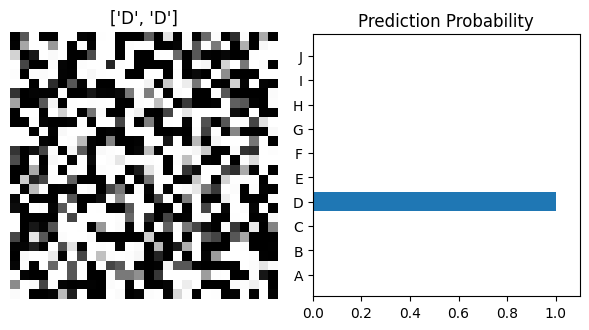

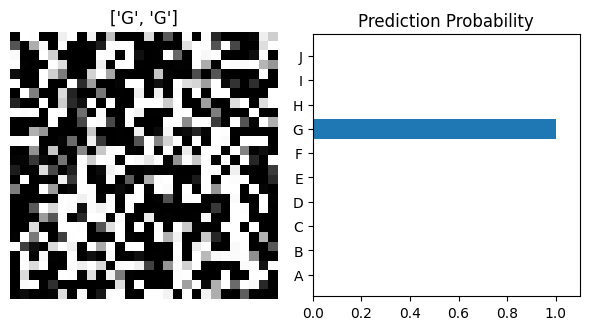

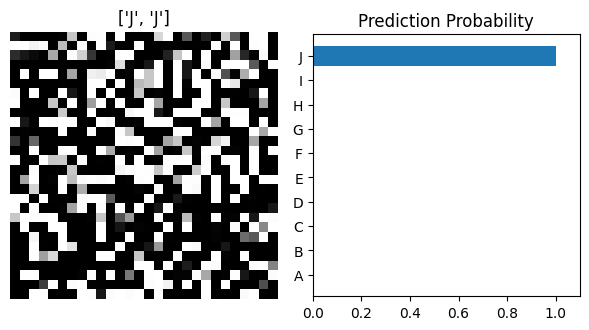

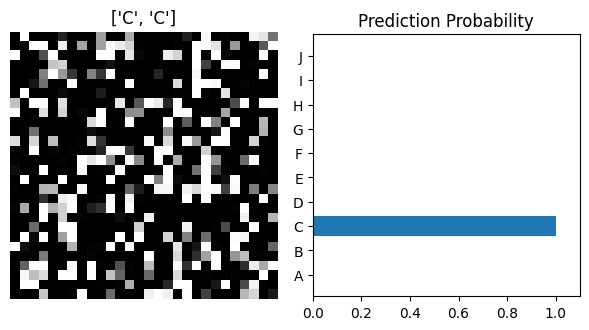

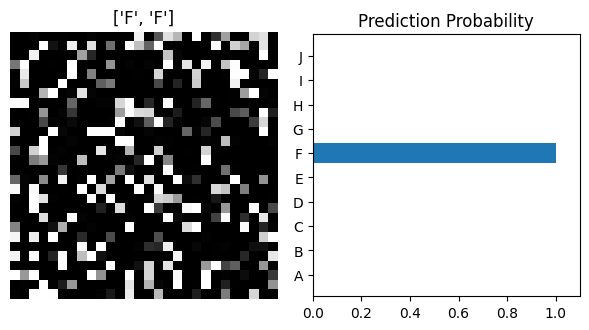

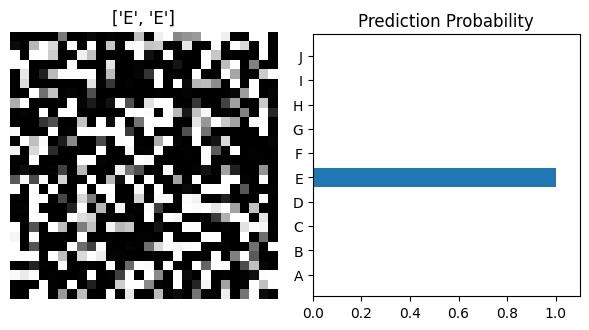

In [21]:
model_cnn2.to('cpu')

####fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn2(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_prediction(img_perm, pred_prob, real_label)

#### **Task-2:Build a Resnet-18 classifier for the Emotion Detection Dataset**
- **Dataset Link:https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data**
- **First train a classifier from scratch**
- **Next, fine-tune a pretrained Resnet-18 on this dataset.**
- **For both cases show the performance on the Test set, and compare results**

In [4]:
### Data Set import from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download the dataset
!kaggle datasets download -d ananthu017/emotion-detection-fer

### unzip the dataset
!unzip -qq emotion-detection-fer.zip


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 1.66GB/s]


In [5]:
### Path of the dataset
train_ds_path='/content/train'
test_ds_path='/content/test'
### Load the dataset
train_data=datasets.ImageFolder(train_ds_path,transform=transforms.ToTensor())
test_data=datasets.ImageFolder(test_ds_path,transform=transforms.ToTensor())

train_load=DataLoader(train_data,batch_size=64,shuffle=True)
test_load=DataLoader(test_data,batch_size=64,shuffle=False)


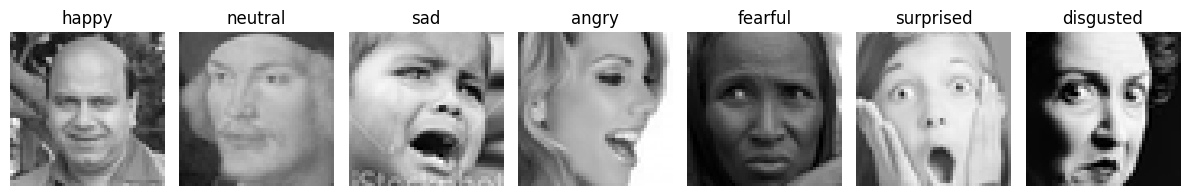

In [6]:
#### Class Names
emotion_class_names = list(train_data.class_to_idx.keys())

fig = plt.figure(figsize=(12, 6))
num_class = len(emotion_class_names)

vis_class = set()  ### Checking which class has been shown

for images, labels in train_load:
    for im, lb in zip(images, labels):
        if lb.item() not in vis_class:
            vis_class.add(lb.item())
            ax = fig.add_subplot(1, num_class, len(vis_class))
            ax.imshow(im.permute(1, 2, 0))
            ax.set_title(emotion_class_names[lb.item()])
            ax.axis('off')
        if len(vis_class) == num_class:
            break
    if len(vis_class) == num_class:
        break
plt.tight_layout()
plt.show()


- ResNet expect 3 channels image(RGB) and image size of 224x224
- So, here we have to transform tha dataset

In [7]:
emotion_train_transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=3),   ## this conver grayscale to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])
emotion_test_transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

train_data=datasets.ImageFolder(train_ds_path,transform=emotion_train_transform)
test_data=datasets.ImageFolder(test_ds_path,transform=emotion_test_transform)

train_load=DataLoader(train_data,batch_size=64,shuffle=True)
test_load=DataLoader(test_data,batch_size=64,shuffle=False)

#### **Load the pre-trained ResNet Model**

In [8]:
resnet=models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [9]:
### Freeze all layers except the final classification layer
for name,param in resnet.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False
    else:
      param.requires_grad=True
### Define the loss function and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(resnet.parameters(),lr=0.001,momentum=0.9)

### This is move the model to the GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet=resnet.to(device)


In [11]:

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    """
    Train and evaluate  resnet18 model, printing loss, accuracy,
    and a classification report .

    Arguments:
        model: resnet18(pretrained model)
        train_loader: DataLoader for training
        test_loader: DataLoader for testing
        criterion: Loss function
        optimizer: Optimizer
        device: "cuda" or "cpu"
        num_epochs: Number of epochs =10
    """
    for epoch in range(num_epochs):
        for phase in ["train", "test"]:
            if phase=="train":
                model.train()
                dataloader=train_loader
            else:
                model.eval()
                dataloader=test_loader

            running_loss=0.0
            correct=0


            if epoch==num_epochs - 1 and phase== "test":
                all_preds=[]
                all_labels=[]

            for inputs, labels in dataloader:
                inputs=inputs.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase=="train":
                        loss.backward()
                        optimizer.step()

                running_loss+=loss.item() * inputs.size(0)
                correct+=torch.sum(preds == labels.data)

                if epoch == num_epochs - 1 and phase == "test":
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = correct.double() / len(dataloader.dataset)

            print(f"Epoch {epoch+1}/{num_epochs} | Phase: {phase} | "
                  f"Loss: {epoch_loss:.4f} | Accuracy: {100*epoch_acc:.2f}%")

    #### Final classification report
    class_names = test_loader.dataset.classes
    print("\nFinal Classification Report on Test Data:")
    print(classification_report(all_labels, all_preds, target_names=emotion_class_names))




In [24]:
train_and_evaluate(resnet, train_load, test_load, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 | Phase: train | Loss: 1.4198 | Accuracy: 45.97%
Epoch 1/10 | Phase: test | Loss: 1.4530 | Accuracy: 44.86%
Epoch 2/10 | Phase: train | Loss: 1.4164 | Accuracy: 46.30%
Epoch 2/10 | Phase: test | Loss: 1.4471 | Accuracy: 45.26%
Epoch 3/10 | Phase: train | Loss: 1.4122 | Accuracy: 46.39%
Epoch 3/10 | Phase: test | Loss: 1.4424 | Accuracy: 45.10%
Epoch 4/10 | Phase: train | Loss: 1.4085 | Accuracy: 46.55%
Epoch 4/10 | Phase: test | Loss: 1.4395 | Accuracy: 45.49%
Epoch 5/10 | Phase: train | Loss: 1.4077 | Accuracy: 46.56%
Epoch 5/10 | Phase: test | Loss: 1.4404 | Accuracy: 45.35%
Epoch 6/10 | Phase: train | Loss: 1.4014 | Accuracy: 46.85%
Epoch 6/10 | Phase: test | Loss: 1.4411 | Accuracy: 45.15%
Epoch 7/10 | Phase: train | Loss: 1.4019 | Accuracy: 46.87%
Epoch 7/10 | Phase: test | Loss: 1.4419 | Accuracy: 44.92%
Epoch 8/10 | Phase: train | Loss: 1.4009 | Accuracy: 46.63%
Epoch 8/10 | Phase: test | Loss: 1.4379 | Accuracy: 45.43%
Epoch 9/10 | Phase: train | Loss: 1.3984 | Accur

#### **Finetune the model**

In [12]:
def finetunig_resenet(num_classes,train_load,testload,device,num_epochs=10):
  """
  Fine tune with different learning rate for different parts of the network
  -- Early layers get very small learning rate
  -- Later Layefs  get higher learning rate

  """
  print("-"*100)
  print("FINE TUNING APPROACH")
  print("-"*100)

  resnet=models.resnet18(pretrained=True)

  ### Unfreze all layers
  for para in resnet.parameters():
    para.requires_grad=True

  ### Modify final layer because our dataset has 7 class
  resnet.fc=nn.Linear(resnet.fc.in_features,num_classes)

  resnet=resnet.to(device)

  ### Now lets define parameter with different learning rate
  param_groups = [
        {'params': [p for n, p in resnet.named_parameters() if 'layer1' in n], 'lr': 0.00001},
      {'params': [p for n, p in resnet.named_parameters() if 'layer2' in n], 'lr': 0.00005},
      {'params': [p for n, p in resnet.named_parameters() if 'layer3' in n], 'lr': 0.0001},
        {'params': [p for n, p in resnet.named_parameters() if 'layer4' in n], 'lr': 0.0005},
        {'params': [p for n, p in resnet.named_parameters() if 'fc' in n], 'lr': 0.001},
        {'params': [p for n, p in resnet.named_parameters() if not any(layer in n for layer in ['layer1', 'layer2', 'layer3', 'layer4', 'fc'])], 'lr': 0.00001}
    ]
#### Loass function and optimizer
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.SGD(param_groups,momentum=0.9)

  #### TRAIN THE MODEL
  train_and_evaluate(resnet, train_load, test_load, criterion, optimizer, device, num_epochs=10)

  return resnet
#### Calling the function after finetuning
finetunig_resenet(7,train_load,test_load,device,num_epochs=10)


----------------------------------------------------------------------------------------------------
FINE TUNING APPROACH
----------------------------------------------------------------------------------------------------
Epoch 1/10 | Phase: train | Loss: 1.4846 | Accuracy: 42.91%
Epoch 1/10 | Phase: test | Loss: 1.2969 | Accuracy: 51.45%
Epoch 2/10 | Phase: train | Loss: 1.2069 | Accuracy: 54.90%
Epoch 2/10 | Phase: test | Loss: 1.1849 | Accuracy: 55.35%
Epoch 3/10 | Phase: train | Loss: 1.0812 | Accuracy: 59.84%
Epoch 3/10 | Phase: test | Loss: 1.1269 | Accuracy: 58.16%
Epoch 4/10 | Phase: train | Loss: 0.9800 | Accuracy: 63.80%
Epoch 4/10 | Phase: test | Loss: 1.1093 | Accuracy: 59.08%
Epoch 5/10 | Phase: train | Loss: 0.8886 | Accuracy: 67.36%
Epoch 5/10 | Phase: test | Loss: 1.1057 | Accuracy: 60.50%
Epoch 6/10 | Phase: train | Loss: 0.7913 | Accuracy: 71.40%
Epoch 6/10 | Phase: test | Loss: 1.0818 | Accuracy: 61.16%
Epoch 7/10 | Phase: train | Loss: 0.6845 | Accuracy: 75.88%
Epo

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **Results Comparison**
#### **For both cases show the performance on the Test set, and compare results**

# 🎭 Emotion Classification Model Performance Comparison

We trained a model to classify emotions from images. Below is a detailed **comparison** of the results **before** and **after fine-tuning**.

---

##  Overall Performance Metrics

| Metric | Pre-trained Model | Fine-tuned Model | Improvement |
|--------|------------------|------------------|-------------|
| **Test Loss** | 1.4385 | 1.2444 | **-0.1941 (-13.5%)** |
| **Test Accuracy** | 45.46% | 62.69% | **+17.23%** |
| **Macro Avg F1-Score** | 0.38 | 0.59 | **+0.21 (+55.3%)** |
| **Weighted Avg F1-Score** | 0.44 | 0.62 | **+0.18 (+40.9%)** |

---

##  Detailed Per-Class Comparison

### Precision Comparison
| Emotion | Pre-trained | Fine-tuned | Improvement |
|---------|-------------|------------|-------------|
| **Angry** | 0.37 | 0.55 | **+0.18** |
| **Disgusted** | 0.19 | 0.62 | **+0.43** |
| **Fearful** | 0.33 | 0.48 | **+0.15** |
| **Happy** | 0.59 | 0.80 | **+0.21** |
| **Neutral** | 0.42 | 0.58 | **+0.16** |
| **Sad** | 0.35 | 0.49 | **+0.14** |
| **Surprised** | 0.58 | 0.80 | **+0.22** |

### Recall Comparison
| Emotion | Pre-trained | Fine-tuned | Improvement |
|---------|-------------|------------|-------------|
| **Angry** | 0.27 | 0.52 | **+0.25** |
| **Disgusted** | 0.04 | 0.41 | **+0.37** |
| **Fearful** | 0.20 | 0.44 | **+0.24** |
| **Happy** | 0.62 | 0.85 | **+0.23** |
| **Neutral** | 0.50 | 0.58 | **+0.08** |
| **Sad** | 0.47 | 0.53 | **+0.06** |
| **Surprised** | 0.61 | 0.75 | **+0.14** |

### F1-Score Comparison
| Emotion | Pre-trained | Fine-tuned | Improvement | Support |
|---------|-------------|------------|-------------|---------|
| **Angry** | 0.32 | 0.54 | **+0.22 (+69%)** | 958 |
| **Disgusted** | 0.06 | 0.49 | **+0.43 (+717%)** | 111 |
| **Fearful** | 0.25 | 0.46 | **+0.21 (+84%)** | 1024 |
| **Happy** | 0.60 | 0.83 | **+0.23 (+38%)** | 1774 |
| **Neutral** | 0.46 | 0.58 | **+0.12 (+26%)** | 1233 |
| **Sad** | 0.40 | 0.51 | **+0.11 (+28%)** | 1247 |
| **Surprised** | 0.59 | 0.77 | **+0.18 (+31%)** | 831 |

---

##  Key Performance Insights

###  **Most Improved Classes:**
1. **Disgusted**: F1-Score improved by **717%** (0.06 → 0.49)
2. **Fearful**: F1-Score improved by **84%** (0.25 → 0.46)  
3. **Angry**: F1-Score improved by **69%** (0.32 → 0.54)

###  **Best Performing Classes After Fine-tuning:**
1. **Happy**: F1-Score = 0.83 (Precision: 0.80, Recall: 0.85)
2. **Surprised**: F1-Score = 0.77 (Precision: 0.80, Recall: 0.75)
3. **Neutral**: F1-Score = 0.58 (Precision: 0.58, Recall: 0.58)

---

## 📋 Complete Classification Reports

###  **Before Fine-Tuning (Pre-trained Model)**
```
              precision    recall  f1-score   support

       angry       0.37      0.27      0.32       958
   disgusted       0.19      0.04      0.06       111
     fearful       0.33      0.20      0.25      1024
       happy       0.59      0.62      0.60      1774
     neutral       0.42      0.50      0.46      1233
         sad       0.35      0.47      0.40      1247
   surprised       0.58      0.61      0.59       831

    accuracy                           0.45      7178
   macro avg       0.40      0.39      0.38      7178
weighted avg       0.45      0.45      0.44      7178
```
**Issues**: Low overall accuracy (45.46%), very poor performance on minority classes

---

###  **After Fine-Tuning**
```
              precision    recall  f1-score   support

       angry       0.55      0.52      0.54       958
   disgusted       0.62      0.41      0.49       111
     fearful       0.48      0.44      0.46      1024
       happy       0.80      0.85      0.83      1774
     neutral       0.58      0.58      0.58      1233
         sad       0.49      0.53      0.51      1247
   surprised       0.80      0.75      0.77       831

    accuracy                           0.63      7178
   macro avg       0.62      0.58      0.59      7178
weighted avg       0.63      0.63      0.62      7178
```
**Improvements**: Significant gains across all classes, much better balance

---

##  **Final Summary & Conclusion**

### Performance Gains:
-  **Accuracy increased by 17.23%** (45.46% → 62.69%)
-  **Loss decreased by 13.5%** (1.4385 → 1.2444)
-  **Macro F1-Score improved by 55.3%** (0.38 → 0.59)
-  **All individual classes showed improvement**

### Key Achievements:
1. **Minority Class Recovery**: The model went from barely detecting "Disgusted" emotions (F1: 0.06) to reasonable performance (F1: 0.49)
2. **Balanced Performance**: No class has extremely poor performance anymore
3. **Overall Reliability**: The model is now suitable for real-world emotion classification tasks
4. **Maintained Strengths**: Classes that performed well before (Happy, Surprised) got even better

### **Conclusion:**
Fine-tuning the pre-trained ResNet18 model dramatically improved emotion classification performance. The model transformed from an unreliable classifier with severe class imbalance issues to a robust emotion recognition system with consistent performance across all emotion categories. This demonstrates the power of transfer learning and fine-tuning for domain-specific tasks.